In [50]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize
from tqdm import tqdm

In [59]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()

## Домашнее задание

### пп. 1)-3) тексты были предобработаны (в том числе удалены стоп-слова) и сохранены в .vw файл при выполненнии задания по gensim

### 4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно);

BigARTM работает не с целым файлом, а с кусочками. Поэтому разбиваем наш .vw файл специальным классом в artm.

In [51]:
batch_vectorizer = artm.BatchVectorizer(data_path='./habr_texts.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches',
                                       batch_size=1000) # размер батча, подбирайте под свою память

Уже созданные батчи можно заново загружать

In [52]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
                                        data_format='batches') # указываем формат - батчи

In [53]:
# инициализируем словарь, чтобы сделать модель
dictionary = artm.Dictionary()

Собираем словарь по батчам

In [54]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df=2000)

artm.Dictionary(name=59da2a4a-6d09-44fa-a023-3217880b75c3, num_entries=15788)

Его можно сохранить, чтобы не создавать снова или чтобы посмотреть и подредактировать.

In [55]:
dictionary.save_text('dict.txt')
# dictionary = artm.Dictionary()
# dictionary.load_text('dict.txt')

Создаем модель и сразу включаем два регуляризатора (Декореляции и Сглаживания)

### 5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем;

`artm.DecorrelatorPhiRegularizer` - регуляризатор декорреляции тем, делает темы менее похожими друг на друга (рекомендуется включать его сразу на всех темах с положительным значением tau и не менять его в процессе обучения)  

`artm.SmoothSparsePhiRegularizer` - регуляризатор сглаживания/разреженивания Phi (тем) - сглаживает или расреживает распределение слов в темах (отрицательный tau - разреживает, положительный - сглаживает), рекомендуется сразу включать сглаживание на всех темах и не менять его в процессе обучения;

Количество тем нужно подбирать, но 200 часто работает хорошо. Снижение количества тем и уменьшения словаря ведут к уменьшению времени обучения модели (а увеличение, наоборот). 

In [143]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(300)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 300)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=-0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 300)])
                                    ]
                        )

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

In [144]:
# инициализурем модель словарем
model_artm.initialize(dictionary=dictionary, )

In [145]:
# добавляем метрики
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

Пройдемся несколько раз по коллекции, чтобы модель немного сошлась (если доков сильно больше то может быть достаточно и 1 прохода). Для сильно больших коллекций есть fit_online, который обновляется в процессе прохода по коллекции, про него можно почитать в документации.

In [146]:
model_artm.num_document_passes = 4
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Sparsity Phi: 0.947 ARTM)
Sparsity Theta: 0.011 (ARTM)
Kernel contrast: 0.387 (ARTM)
Kernel purity: 0.461 (ARTM)
Perplexity: 1508.954 (ARTM)


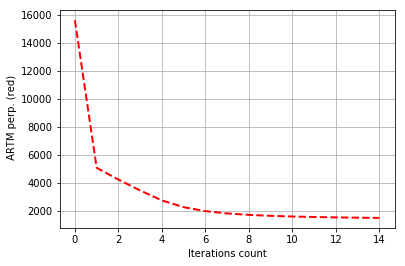

In [147]:
# посмотрим, что стало с моделью
# если график сильно падал на последних итерациях, то можно прогнать обучение ещё несколько раз 
# (не добавляя другие регуляризаторы)
print_measures(model_artm)

Добавим регуляризаторы разреженности тем и документов.

Их рекомендуется добавлять после того, как модель уже как-то сошлась. После добавления их рекомендуется постепенно уменьшать, чтобы усиливать разреживание. Их можно применять не ко всем темам, чтобы в каких-то темах собрались все стоп-слова.

Можно добавлять их вместе или по отдельности.

In [148]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 300)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 300)]))

In [149]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [150]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=3)
    

Sparsity Phi: 0.979 ARTM)
Sparsity Theta: 0.627 (ARTM)
Kernel contrast: 0.439 (ARTM)
Kernel purity: 0.653 (ARTM)
Perplexity: 1397.616 (ARTM)


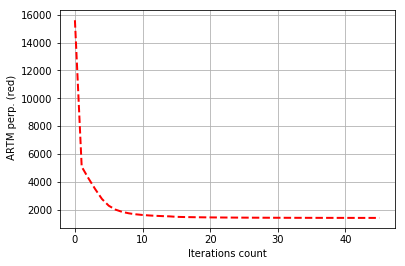

In [151]:
# посмотрим на качество
print_measures(model_artm)

Перплексия должна снижаться. Если график выровнился и больше не меняется - модель сошлась. Обычно перплексия хорошей модели около 200-1000. На таком небольшом количестве данных возможно такого значения достичь не получится.

In [152]:
# посмотрим на темы
for topic_name in model_artm.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
        continue

topic_0: 
использование
состояние
позволять
механизм
использоваться
различный
необходимый
являться
способ
требовать
---------
topic_1: 
компьютер
ноутбук
компьютерный
пк
техника
dell
lenovo
операционный
dos
hp
---------
topic_2: 
регистратор
китайский
gps
ch
шейдёр
dr
sp
линейка
модель
китаец
---------
topic_3: 
успех
сила
усилие
дело
оставаться
результат
приносить
ценность
оказаться
трудность
---------
topic_4: 
экран
дисплей
разрешение
гб
память
дюймовый
доллар
hd
стоить
дюйм
---------
topic_5: 
аппарат
водитель
режим
дрон
ремонт
оснастить
метр
автономный
минута
серийный
---------
topic_6: 
передача
стандарт
поддерживать
спецификация
передавать
поддерживаться
существующий
большинство
распространить
использоваться
---------
topic_7: 
кэш
очередь
scrum
админ
agile
быстро
спринт
кэширование
memcached
либо
---------
topic_8: 
var
function
text
html
style
document
script
id
div
button
---------
topic_9: 
питание
напряжение
ток
аккумулятор
батарея
режим
ибп
вт
мощность
ёмкость
---------
to

### 6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

topic_1: компьютер, ноутбук, компьютерный, пк, техника, dell, lenovo, операционный, dos, hp
    
topic_10: 
доход
налог
рубль
налоговый
ооо
предприниматель
услуга
ип
сумма
договор

topic_24: 
глаз
операция
линза
оптический
разрез
хирург
коррекция
пациент
клиника
поверхность

### 7) в другой ячейке нарисуйте график обучения этой модели

Sparsity Phi: 0.979 ARTM)
Sparsity Theta: 0.627 (ARTM)
Kernel contrast: 0.439 (ARTM)
Kernel purity: 0.653 (ARTM)
Perplexity: 1397.616 (ARTM)


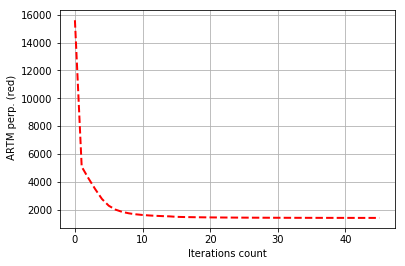

In [154]:
print_measures(model_artm)

### 8) в третьей ячейке опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

В итоге получилось снизить перплексию до 1397 с изначальных 1754 за счет увеличения количества тем до 300 (снижение до 150 снижало качество модели), использования отрицательного tau -0.15 для разреживания тем, регуляризатор корреляции лучше всего работает при исходном значении 0.25 (при снижении или увеличении этого значения качество снижалось). Регуляризаторы разреженности добавлялись после 15 проходов по коллекции и 4 по документу (с увеличением количества подходов качество улучшалось). В целом даже при самом высоком значении перплексии темы выделялись хорошо и разница с конечной моделью небольшая.